In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from IndustryMap2 import industry_categories

In [2]:
df = pd.read_csv('../SavedData/dataset2_cleaned.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Remove capitalization and spaces from 'Third Party Name' column
df['Third Party Name'] = df['Third Party Name'].str.lower().str.replace(' ', '')

In [3]:
training_transactions, testing_transactions = train_test_split(df, test_size=0.2, random_state=2)

## Remove certain industries

In [4]:
# Find all keys in the dictionary where the value is 'subscription' or 'finance'
companies_to_remove = [company for company, category in industry_categories.items()
                       if category in ['subscription', 'finance']]
companies_to_remove.append('grandunionbjj')
training_transactions = training_transactions[~((training_transactions['Third Party Name'] == 'amazon') & (training_transactions['Amount'] == -7.99))]
testing_transactions = testing_transactions[~((testing_transactions['Third Party Name'] == 'amazon') & (testing_transactions['Amount'] == -7.99))]

training_transactions = training_transactions[~training_transactions['Third Party Name'].isin(companies_to_remove)]
testing_transactions = testing_transactions[~testing_transactions['Third Party Name'].isin(companies_to_remove)]

## Changing Values to Positive Absolute

In [5]:
training_payments_df = training_transactions[training_transactions['Amount'] > 0].copy()
training_expenditures_df = training_transactions[training_transactions['Amount'] < 0].copy()
training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()

testing_payments_df = testing_transactions[testing_transactions['Amount'] > 0].copy()
testing_expenditures_df = testing_transactions[testing_transactions['Amount'] < 0].copy()
testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()

In [6]:
training_expenditures_df = training_expenditures_df.copy()
testing_expenditures_df = testing_expenditures_df.copy()

training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
training_expenditures_df['DayOfMonth'] = training_expenditures_df['Datetime'].dt.day
training_expenditures_df['MonthOfYear'] = training_expenditures_df['Datetime'].dt.month

testing_expenditures_df['DayOfWeek'] = testing_expenditures_df['Datetime'].dt.dayofweek
testing_expenditures_df['DayOfMonth'] = testing_expenditures_df['Datetime'].dt.day
testing_expenditures_df['MonthOfYear'] = testing_expenditures_df['Datetime'].dt.month

In [7]:
training_expenditures_df = training_expenditures_df.copy()
testing_expenditures_df = testing_expenditures_df.copy()

training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour
testing_expenditures_df['Hour'] = testing_expenditures_df['Datetime'].dt.hour

In [8]:
patterns_train = training_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Third Party Name'])['Amount'].sum().reset_index()
patterns_test = testing_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Third Party Name'])['Amount'].sum().reset_index()

## Building Model Dictionary

In [9]:
account_no = list(df['Account No'].unique())
key_list = account_no
value_list = [0] * len(account_no)
account_num_models = dict(zip(key_list, value_list))

## Training Model Dictionary

In [10]:
for account in account_no:
    X_train = patterns_train[patterns_train['Account No'] == account][['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
    X_test = patterns_test[patterns_test['Account No'] == account][['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    user_model = IsolationForest(n_estimators=100, contamination=0.025)
    account_num_models[account] = user_model.fit(X_train_scaled)
    
    predictions = account_num_models[account].predict(X_test_scaled)
    
    # Save predictions to the DataFrame
    patterns_test.loc[X_test.index, 'Prediction'] = predictions
    
# Check the DataFrame to see the predictions column
print(patterns_test.head())

    Account No  Hour  DayOfWeek  DayOfMonth  MonthOfYear Third Party Name  \
0  101531259.0     8          0          19            6            tesco   
1  101531259.0     8          2          11           10            tesco   
2  101531259.0     8          5          12            8            tesco   
3  101531259.0     9          3          30           11    fivesensesart   
4  101531259.0     9          5          30            9     sportsdirect   

   Amount  Prediction  
0  161.08         1.0  
1   65.20         1.0  
2   95.92         1.0  
3    7.49         1.0  
4   30.99         1.0  


## Pruning for Anomalous Transactions

In [11]:
anomaly_tx = patterns_test[patterns_test['Prediction'] == -1]

In [12]:
# Calculate Q1 and Q3
business_groups = anomaly_tx.groupby('Third Party Name')['Amount']
iqr_dict = {name: {'Q1': group.quantile(0.25), 'Q3': group.quantile(0.75), 'IQR': group.quantile(0.75) - group.quantile(0.25)} 
            for name, group in business_groups}

In [13]:
#Function to categorize the anomaly transactions
def tx_risk_category(row):
    business = row['Third Party Name']
    amount = row['Amount']
    if business in iqr_dict:
        q1 = iqr_dict[business]['Q1']
        q3 = iqr_dict[business]['Q3']
        iqr = iqr_dict[business]['IQR']
        medium_risk = q3
        high_risk = q3 + 1.5 * iqr 
        
        if amount > high_risk:
            return 'High Risk'
        elif amount > medium_risk:
            return 'Medium Risk'
        else:
            return 'Low Risk'
    else:
        return 'Unknown'

anomaly_tx['Risk Category'] = anomaly_tx.apply(tx_risk_category, axis=1)

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_60123/3532302480.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_tx['Risk Category'] = anomaly_tx.apply(tx_risk_category, axis=1)


In [14]:
anomaly_tx[anomaly_tx['Risk Category'] == 'High Risk']

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Name,Amount,Prediction,Risk Category
1228,134847904.0,20,1,31,1,tesco,291.03,-1.0,High Risk
1482,143003091.0,13,5,28,1,sportsdirect,299.97,-1.0,High Risk
5291,248625662.0,8,5,18,3,tesco,291.57,-1.0,High Risk
5532,254853117.0,13,6,26,2,tesco,284.32,-1.0,High Risk
7025,290818242.0,16,6,3,12,topshop,466.20,-1.0,High Risk
8582,340321732.0,10,6,9,4,tesco,301.17,-1.0,High Risk
9018,349107386.0,11,6,19,3,tesco,284.37,-1.0,High Risk
9395,364357875.0,10,4,7,4,matalan,514.50,-1.0,High Risk
10746,407574996.0,11,4,25,8,tesco,321.22,-1.0,High Risk
10751,407574996.0,12,4,27,1,topshop,449.40,-1.0,High Risk


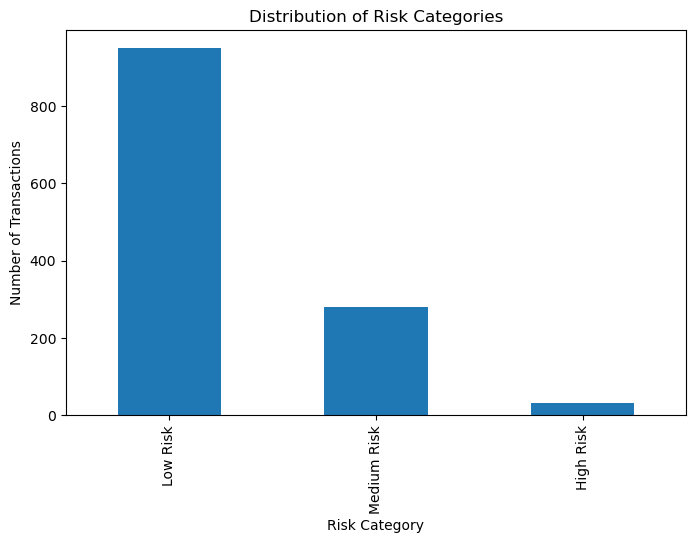

In [15]:
import matplotlib.pyplot as plt

no_of_risk = anomaly_tx['Risk Category'].value_counts()
plt.figure(figsize=(8, 5))
no_of_risk.plot(kind='bar')
plt.title('Distribution of Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Number of Transactions')
plt.show()

In [17]:
anomaly_tx.to_csv("Isolation_forest_results.csv", index= False)